In [ ]:
# main imports
import os
import sys
import glob
import math
import shutil
import random
import importlib
import subprocess

import numpy as np
import pandas as pd

from itertools import product

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import seaborn as sns
from joypy import joyplot

plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.size'] = 24
%matplotlib inline

In [ ]:
pd.set_option('display.max_columns', None)

%load_ext autoreload
%autoreload 1

sys.path.insert(0, "/ccb/salz8-1/avaraby/orfanage/soft")
%aimport definitions

In [ ]:
# paths

base_dir = "/ccb/salz8-1/avaraby/orfanage/"

orfanage_bin = base_dir+"bin/orfanage"
gffcompare_bin = "/ccb/salz7-data/sw2/bin/gffcompare"
gffread_bin = "/ccb/salz7-data/sw2/bin/gffread"
igvtools_bin = "/ccb/salz7-data/sw/bin/igvtools"
sashimi_bin = base_dir+"bin/sashimi.py"

fa_fname = base_dir+"data/celegans.fa"
gtf_fname = base_dir+"data/celegans.gtf"

outdir = base_dir+"celegans/"
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [ ]:
# arguments
num_threads = 30

In [5]:
gtf_adjstop_fname = gtf_fname.rsplit(".",1)[0]+".adjstop.gtf"
gtf_adjstop_sorted_fname = gtf_adjstop_fname.rsplit(".",1)[0]+".sorted.gtf"
gtf_adjstop_aa_fa_fname = gtf_adjstop_fname.rsplit(".",1)[0]+".aa.fa"

clean_gtf_fname = gtf_adjstop_fname.rsplit(".",1)[0]+".clean.gtf"
nocds_gtf_fname = clean_gtf_fname.rsplit(".",1)[0]+".nocds.gtf"

out_gtf_fname = outdir+"orf.gtf"
out_stats_fname = outdir+"orf.stats"
out_gtf_sorted_fname = out_gtf_fname.rsplit(".",1)[0]+".sorted.gtf"

out_df_tsv_fname = outdir+"df.tsv"

In [6]:
# standardize the annotation - adjust stop, discard anything without a start/stop codon
cmd = [gffread_bin,
       "-g",fa_fname,
       "--adj-stop","-T","-F","-J",
       "-o",gtf_adjstop_fname,
       gtf_fname]

print(" ".join(cmd))
subprocess.call(cmd)

igv_cmd = [igvtools_bin,"sort",gtf_adjstop_fname,gtf_adjstop_sorted_fname]
print(" ".join(igv_cmd))
subprocess.call(igv_cmd)
igv_cmd = [igvtools_bin,"index",gtf_adjstop_sorted_fname]
print(" ".join(igv_cmd))
subprocess.call(igv_cmd)

cmd = [gffread_bin,
       "-y",gtf_adjstop_aa_fa_fname,
       "-g",fa_fname,
       gtf_adjstop_fname]

print(" ".join(cmd))
subprocess.call(cmd)

/ccb/salz7-data/sw2/bin/gffread -g /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --adj-stop -T -F -J -o /ccb/salz8-1/avaraby/orfanage/data/celegans.adjstop.gtf /ccb/salz8-1/avaraby/orfanage/data/celegans.gtf


FASTA index file /ccb/salz8-1/avaraby/orfanage/data/celegans.fa.fai created.


/ccb/salz7-data/sw/bin/igvtools sort /ccb/salz8-1/avaraby/orfanage/data/celegans.adjstop.gtf /ccb/salz8-1/avaraby/orfanage/data/celegans.adjstop.sorted.gtf
Sorting /ccb/salz8-1/avaraby/orfanage/data/celegans.adjstop.gtf  -> /ccb/salz8-1/avaraby/orfanage/data/celegans.adjstop.sorted.gtf
Done
/ccb/salz7-data/sw/bin/igvtools index /ccb/salz8-1/avaraby/orfanage/data/celegans.adjstop.sorted.gtf
Done
/ccb/salz7-data/sw2/bin/gffread -y /ccb/salz8-1/avaraby/orfanage/data/celegans.adjstop.aa.fa -g /ccb/salz8-1/avaraby/orfanage/data/celegans.fa /ccb/salz8-1/avaraby/orfanage/data/celegans.adjstop.gtf


Error: discarding overlapping duplicate transcript feature (2136646-2136923) with ID=id-CELE_C40A11.10-2
Error: discarding overlapping duplicate transcript feature (2136652-2136923) with ID=id-CELE_C40A11.10
Error: discarding overlapping duplicate transcript feature (2137240-2137329) with ID=id-CELE_C40A11.10
Error: discarding overlapping duplicate transcript feature (2137240-2137329) with ID=id-CELE_C40A11.10-2


0

In [7]:
# get ids to remove
# 1. seleno
# 2. polycistronic
# 3. other

# polycistronic
df = definitions.get_chains(gtf_fname,"CDS",True)
df = df[df["has_cds"]==1].reset_index(drop=True)
df["seqid"]=df["coords"].str.split(":",n=1,expand=True)[0]
df["start"] = df["chain"].apply(lambda row: row[0][0])
df["end"] = df["chain"].apply(lambda row: row[-1][1])
# add gene ids
gid=pd.read_csv(gtf_fname,sep="\t",names=definitions.gff3cols,comment="#")
gid=gid[gid["type"]=="transcript"].reset_index(drop=True)
gid["tid"]=gid["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
gid["gid"]=gid["attributes"].str.split("gene_id \"",expand=True)[1].str.split("\"",expand=True)[0]
gid = gid[["gid","tid"]]

df = df.merge(gid,on="tid",how="left",indicator=False)

df["start"] = df["start"].astype(int)
df["end"] = df["end"].astype(int)

df.sort_values(by=["seqid","strand","start","end"],ascending=True,inplace=True)

df = df.groupby(by=["seqid","strand","gid"]).agg({"start":min,"end":max}).reset_index()
df.sort_values(by=["seqid","strand","start","end"],ascending=True,inplace=True)
df["nc"]=df.seqid.shift(-1)
df["nt"]=df.strand.shift(-1)
df["ns"]=df.start.shift(-1)
df["nid"]=df.gid.shift(-1)
df.fillna(0,inplace=True)
df["od"] = np.where((df["seqid"]==df["nc"]) & 
                           (df["strand"]==df["nt"]) & 
                           (df["end"]>df["ns"]),1,0)
pids = set(df[df["od"]==1]["gid"]).union(set(df[df["od"]==1]["nid"]))
print("number of poly: "+str(len(pids)))

# seleno and other exceptions

df=pd.read_csv(gtf_fname,sep="\t",names=definitions.gff3cols,comment="#")
df=df[df["type"]=="transcript"].reset_index(drop=True)
df["tid"]=df["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
df["gid"]=df["attributes"].str.split("gene_id \"",expand=True)[1].str.split("\"",expand=True)[0]
df["attr"]=df["attributes"].str.split("exception \"",expand=True)[1].str.split("\"",expand=True)[0]
df["seleno"] = df["attributes"].str.lower().str.contains("selen")

sids = set(df[df["seleno"]]["gid"])
print("number of seleno: "+str(len(sids)))

print("exceptions: "+", ".join(list(set(df[~(df["attr"].isna())]["attr"].tolist()))))
eids = set(df[~(df["attr"].isna())]["gid"])
print("number of exceptions: "+str(len(eids)))

number of poly: 202
number of seleno: 6
exceptions: low-quality sequence region, ribosomal slippage
number of exceptions: 13


In [8]:
dirty_gids = pids.union(sids).union(eids)
print("number of genes to discard: "+str(len(dirty_gids)))

number of genes to discard: 221


In [9]:
# create a file without transcripts in these genes
with open(clean_gtf_fname,"w+") as outFP:
    with open(gtf_adjstop_fname,"r") as inFP:
        for line in inFP:
            lcs = line.split("\t")
            gid = lcs[8].split("gene_id \"",1)[1].split("\"",1)[0]
            if not gid in dirty_gids:
                outFP.write(line)

In [10]:
# create input without CDS in it (easier to explain than "not using --keep_cds")
with open(nocds_gtf_fname,"w+") as outFP:
    with open(gtf_fname,"r") as inFP:
        for line in inFP:
            lcs = line.split("\t")
            if lcs[2]=="CDS":
                continue
            
            outFP.write(line)

In [12]:
# run orfanage on self

cmd = [orfanage_bin,
       "--reference",fa_fname,
       "--query",nocds_gtf_fname,
       "--threads",str(num_threads),
       "--output",out_gtf_fname,
       "--stats",out_stats_fname,
       "--non_aug",
       clean_gtf_fname]
print(" ".join(cmd))
subprocess.call(cmd)

igv_cmd = [igvtools_bin,"sort",out_gtf_fname,out_gtf_sorted_fname]
print(" ".join(igv_cmd))
subprocess.call(igv_cmd)
igv_cmd = [igvtools_bin,"index",out_gtf_sorted_fname]
print(" ".join(igv_cmd))
subprocess.call(igv_cmd)

/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/data/celegans.adjstop.clean.nocds.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.gtf --stats /ccb/salz8-1/avaraby/orfanage/celegans/orf.stats --non_aug /ccb/salz8-1/avaraby/orfanage/data/celegans.adjstop.clean.gtf


loading reference genome
loading reference transcriptomes
Error: discarding overlapping duplicate transcript feature (2136646-2136923) with ID=id-CELE_C40A11.10-2
Error: discarding overlapping duplicate transcript feature (2136652-2136923) with ID=id-CELE_C40A11.10
Error: discarding overlapping duplicate transcript feature (2137240-2137329) with ID=id-CELE_C40A11.10
Error: discarding overlapping duplicate transcript feature (2137240-2137329) with ID=id-CELE_C40A11.10-2
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz7-data/sw/bin/igvtools sort /ccb/salz8-1/avaraby/orfanage/celegans/orf.gtf /ccb/salz8-1/avaraby/orfanage/celegans/orf.sorted.gtf
Sorting /ccb/salz8-1/avaraby/orfanage/celegans/orf.gtf  -> /ccb/salz8-1/avaraby/orfanage/celegans/orf.sorted.gtf
Done
/ccb/salz7-data/sw/bin/igvtools index /ccb/salz8-1/avaraby/orfanage/celegans/orf.sorted.gtf
Done


0

total number of genes with CDS in them: 20995
total number of transcript with CDS: 29429
number of genes with multiple coding isoforms: 4422
number of transcripts in genes with multiple coding isoforms: 12856


/ccb/salz8-3/avaraby1/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='count'>

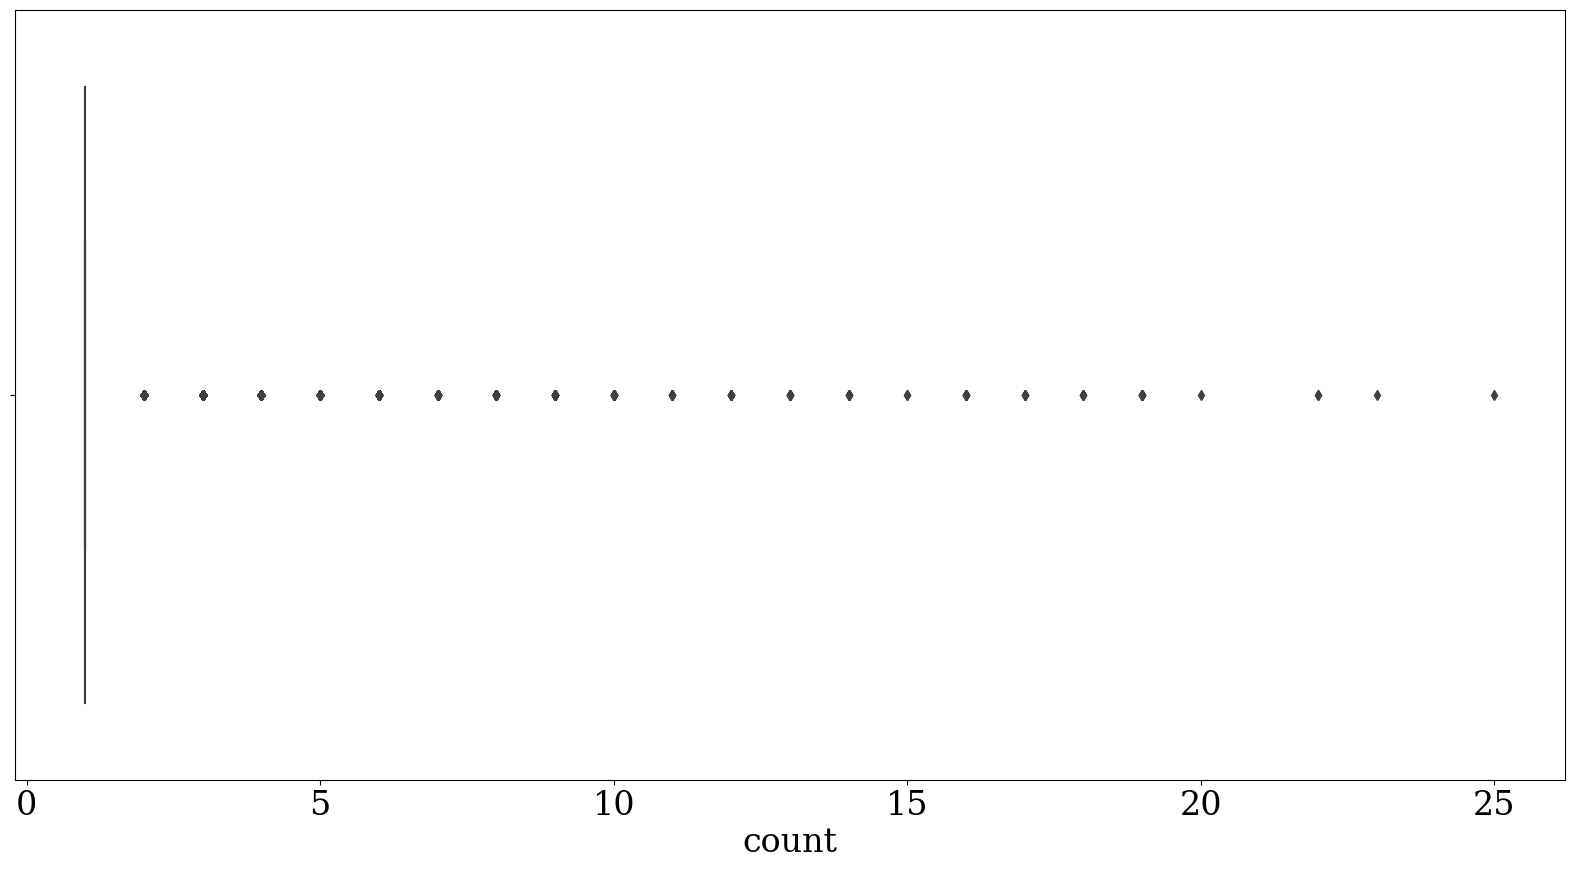

In [9]:
# how well does it work if we randomly pick one cds for each gene and use that to re-annotate?

# this can be run several times to get the distribution

df=pd.read_csv(clean_gtf_fname,sep="\t",names=definitions.gff3cols,comment="#")
cdf=df[df["type"]=="CDS"].reset_index(drop=True)
cdf["tid"]=cdf["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
cdf["gid"]=cdf["attributes"].str.split("gene_id \"",expand=True)[1].str.split("\"",expand=True)[0]

rdf = cdf[~cdf["gid"].isnull()][["tid",
                               "gid"]].drop_duplicates(keep="first").groupby(by="gid").agg({"tid":["count",
                                                                                                         lambda grp: set(grp)]}).reset_index()
rdf.columns = ["gid","count","list"]

print("total number of genes with CDS in them: "+str(len(rdf)))
print("total number of transcript with CDS: "+str(rdf["count"].sum()))
print("number of genes with multiple coding isoforms: "+str(len(rdf[rdf["count"]>1])))
print("number of transcripts in genes with multiple coding isoforms: "+str(rdf[rdf["count"]>1]["count"].sum()))

mrdf = rdf[rdf["count"]>1].reset_index(drop=True)

sns.boxplot(rdf["count"])

In [10]:
num_rands = 10
percs = [0,0.25,0.50,0.75]
out_gtf_fname = outdir+"orf.gtf"

ref_gids = set(mrdf["gid"])

for p in percs:
    for i in range(num_rands):
        # for each gene get 1 random CDS and everything else
        ref_tids = set()
        q_tids = set()
        for idx,row in mrdf.iterrows():
            nrs = int(max(1,float(len(list(row["list"])))*p))
            rs = random.sample(list(row["list"]),nrs)
            for r in rs:
                ref_tids.add(r)
            for v in row["list"]:
                if v in rs:
                    continue
                else:
                    q_tids.add(v)

        rand_gtf_fname = out_gtf_fname.rsplit(".",1)[0]+".rand_"+str(int(p*100))+"."+str(i)+".gtf"

        with open(rand_gtf_fname,"w+") as outFP:
            with open(clean_gtf_fname,"r") as inFP:
                for line in inFP:
                    lcs = line.split("\t")
                    if not len(lcs) == 9:
                        continue

                    tid = lcs[8].split("transcript_id \"", 1)[1].split("\"", 1)[0]
                    if tid in ref_tids:
                        outFP.write(line)
                    else:
                        if tid in q_tids:
                            if not lcs[2]=="CDS":
                                outFP.write(line)

        rand_orf_gtf_fname = rand_gtf_fname.rsplit(".",1)[0]+".orf.gtf"

        cmd = [orfanage_bin,
               "--reference",fa_fname,
               "--query",rand_gtf_fname,
               "--threads",str(num_threads),
               "--output",rand_orf_gtf_fname,
               "--non_aug",
               "--keep_cds",
               rand_gtf_fname]
        print(" ".join(cmd))
        subprocess.call(cmd)

/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_0.0.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_0.0.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_0.0.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_0.1.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_0.1.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_0.1.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_0.2.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_0.2.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_0.2.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_0.3.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_0.3.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_0.3.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_0.4.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_0.4.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_0.4.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_0.5.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_0.5.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_0.5.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_0.6.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_0.6.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_0.6.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_0.7.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_0.7.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_0.7.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_0.8.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_0.8.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_0.8.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_0.9.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_0.9.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_0.9.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_25.0.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_25.0.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_25.0.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_25.1.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_25.1.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_25.1.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_25.2.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_25.2.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_25.2.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_25.3.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_25.3.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_25.3.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_25.4.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_25.4.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_25.4.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_25.5.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_25.5.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_25.5.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_25.6.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_25.6.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_25.6.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_25.7.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_25.7.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_25.7.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_25.8.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_25.8.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_25.8.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_25.9.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_25.9.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_25.9.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_50.0.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_50.0.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_50.0.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_50.1.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_50.1.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_50.1.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_50.2.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_50.2.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_50.2.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_50.3.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_50.3.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_50.3.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_50.4.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_50.4.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_50.4.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_50.5.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_50.5.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_50.5.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_50.6.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_50.6.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_50.6.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_50.7.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_50.7.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_50.7.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_50.8.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_50.8.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_50.8.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_50.9.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_50.9.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_50.9.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_75.0.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_75.0.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_75.0.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_75.1.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_75.1.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_75.1.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_75.2.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_75.2.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_75.2.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_75.3.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_75.3.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_75.3.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_75.4.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_75.4.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_75.4.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_75.5.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_75.5.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_75.5.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_75.6.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_75.6.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_75.6.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_75.7.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_75.7.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_75.7.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_75.8.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_75.8.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_75.8.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/celegans.fa --query /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_75.9.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_75.9.orf.gtf --non_aug --keep_cds /ccb/salz8-1/avaraby/orfanage/celegans/orf.rand_75.9.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


In [11]:
# load reference chains
ref_df = definitions.get_chains(clean_gtf_fname,"CDS",True)

res = dict()
res_ilpd = pd.DataFrame()

for p in percs:
    for i in range(num_rands):
        rand_gtf_fname = out_gtf_fname.rsplit(".",1)[0]+".rand_"+str(int(p*100))+"."+str(i)+".gtf"
        rand_orf_gtf_fname = rand_gtf_fname.rsplit(".",1)[0]+".orf.gtf"

        # load orf and compare to red
        q_df = definitions.get_chains(rand_orf_gtf_fname,"CDS",False)
        q_adf = definitions.get_attribute(rand_orf_gtf_fname,"orfanage_template")
        q_df = q_df.merge(q_adf,on="tid",how='left')
        comp_df = q_df.merge(ref_df,on="tid",how="left")
        comp_df.columns = ["tid","orf_has_cds","orf_chain","orf_templ","ref_has_cds","seqid","strand","coords","ref_chain"]
        comp_df[["mod_chain",
                "c1len",
                "c2len",
                "match_start",
                "match_end",
                "num_bp_extra",
                "num_bp_missing",
                "num_bp_inframe",
                "num_bp_match",
                "num_bp_outframe",
                "lpd",
                "ilpd",
                "mlpd"]] = comp_df.apply(lambda row: definitions.compare_and_extract(row["orf_chain"],row["ref_chain"],row["strand"]),axis=1)
        comp_df.drop(["match_start","match_end","num_bp_match","lpd","mlpd"],axis=1,inplace=True)
        
        ilpd_df = comp_df[["ilpd"]].reset_index(drop=True)
        ilpd_df["perc"] = p
        ilpd_df["iter"] = i
        res_ilpd = pd.concat([res_ilpd,ilpd_df],axis=0)

        # get some numbers
        nmt = len(comp_df[(comp_df["ref_has_cds"]==1)&(comp_df["orf_has_cds"]==0)]) # number of missing CDS
        nmr = len(comp_df[comp_df["ref_chain"]==comp_df["orf_chain"]]) # number with matching chains
        nnr = len(comp_df[~(comp_df["ref_chain"]==comp_df["orf_chain"])]) # number with mis-matching chains
        mean_ilpd = comp_df["ilpd"].mean()

        res[str(i)+"."+str(p)] = [i,p,nmt,nmr,nnr,mean_ilpd]
        
res_ilpd.to_csv(out_gtf_fname.rsplit(".",1)[0]+".rand.ilpd.tsv",sep="\t",index=False)

res = pd.DataFrame.from_dict(res,orient="index").reset_index()
res.columns = ["idx","iter","perc","missing","matching","mismatching","mean_ilpd"]
res.drop("idx",axis=1,inplace=True)
res.to_csv(out_gtf_fname.rsplit(".",1)[0]+".rand.tsv",sep="\t",index=False)
for v in res.columns:
    print(v+": mean ",str(res[v].mean())+","+str(res[v].std()))
res.head()

iter: mean  4.5,2.908872369413698
perc: mean  0.375,0.28306925853614895
missing: mean  66.475,36.04198940125253
matching: mean  10673.425,639.1505535695054
mismatching: mean  2175.9,636.6325994375928
mean_ilpd: mean  94.46544552601236,1.8681877498518336


,iter,perc,missing,matching,mismatching,mean_ilpd
0,0,0.0,96,10008,2839,92.454970
1,1,0.0,112,10034,2814,92.562889
2,2,0.0,102,9921,2926,92.381412
3,3,0.0,109,10025,2820,92.767458
4,4,0.0,112,9857,2990,91.923718


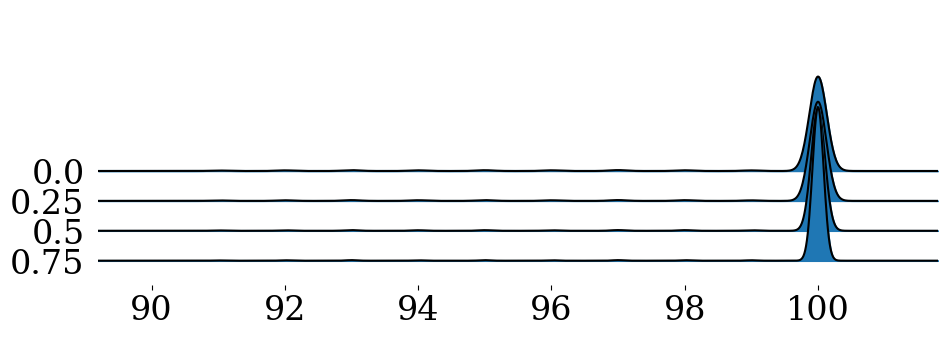

In [12]:
res_ilpd = pd.read_csv(out_gtf_fname.rsplit(".",1)[0]+".rand.ilpd.tsv",sep="\t")
res = pd.read_csv(out_gtf_fname.rsplit(".",1)[0]+".rand.tsv",sep="\t")

fig,axes = joyplot(res_ilpd[res_ilpd["ilpd"]>90][["perc","ilpd"]],by='perc',column='ilpd',figsize=(10,4))
plt.show()